# Combined Time-Frequency Stimulus Response Figures

In [1]:
save_folder = '/home/jtauber/Documents/MillerData/analysis2/lfp/spectral/spectrogram/total_power/figures/'
save_figs = True

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.multitest as mt
import scipy.stats as st
import seaborn as sns

from pap.view import get_colors
from pap.utils import pickle_open
from pap.view import plot_spectrogram
import neural_analysis as na

sns.set()
sns.set_style('ticks')
sns.set_context('talk')

In [3]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':'Arial'})

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

In [4]:
all_results_jones = pickle_open('jones_total_power_400_fw4.pickle')
all_results_mary = pickle_open('mary_total_power_400_fw4.pickle')

all_results = xr.concat([all_results_mary, all_results_jones], dim='session')

In [5]:
sids = all_results.session.data
conds = all_results.cond.data
areas = all_results.area.data
stims = all_results.stim.data

base_freq = all_results.freqs.data
timepts = all_results.timepts.data

In [6]:
np.where(timepts < 0)[0].size

6

In [7]:
stims_print = ['tone_only', 'cpt_tone', 'puff_only']
areas_ord = ['CPB', '7b', 'FEF', 'vlPFC']
conv_label = {'vlPFC': 'PFC',
              'FEF': '8A',
              'CPB': 'STG',
              '7b': 'PPC'}
name_conv = {'tone_only': 'Tone 1',
             'puff_only': 'UC Puff',
             'cpt_tone': 'Tone 2',
             'cpt_puff': 'C Puff'}

In [8]:
db_change_results = all_results.copy()

# baseline_cut = np.where()

for sid in sids:
    for cond in conds:
        for area in areas:
            for stim in stims:
                raw_data = all_results.loc[sid,cond,area,stim,:,:].data
                baseline = raw_data[:,:4].mean(1)[:,None]
                db_change = 10*np.log10(raw_data / baseline)
            
                db_change_results.loc[sid,cond,area,stim,:,:] = db_change
        
    

In [9]:
def cut_spec(spec, freq, cut_low, cut_high):
    cut_ind_high = np.where(freq <= cut_high)[0][-1] + 1
    cut_ind_low = np.where(freq >= cut_low)[0][0]
    
    return spec[:,cut_ind_low:cut_ind_high], freq[cut_ind_low:cut_ind_high]

In [10]:
awake = db_change_results.loc[:,'awake',area,stim,:,:].mean('session')

In [34]:
xticks = np.arange(-0.25, 0.75, 0.25)

In [35]:
xticks

array([-0.25,  0.  ,  0.25,  0.5 ])

In [58]:
def plot_db_change_results_new(stim, cut_low, cut_high):
    fwer = 0.05
    
    fig, ax = plt.subplots(4,3, figsize=(16,12), gridspec_kw={'width_ratios': (1,1,1)}, sharex=True, sharey=True)
    freq_orig = db_change_results.freqs.data
    
    low = -5
    high = 5
    
    phase_fontsize = 32
    tick_fontsize = 28
    tick_start = 10
    xticks = np.arange(-0.25, 1, 0.25)
    
    tick_space = 20
    
    label_fontsize = 32
    
    
    for i, area in enumerate(areas):
        awake = db_change_results.loc[:,'awake',area,stim,:,:].mean('session')
        drug = db_change_results.loc[:,'drug2',area,stim,:,:].mean('session')
        
        awake, freq = cut_spec(awake, freq_orig, cut_low, cut_high)
        drug, _ = cut_spec(drug, freq_orig, cut_low, cut_high)
        reshape = awake.shape
        
        n_sessions = db_change_results.session.data.size
        stats_awake = db_change_results.loc[:,'awake',area,stim,:,:].data
        stats_drug = db_change_results.loc[:,'drug2',area,stim,:,:].data
        
        stats_awake, _ = cut_spec(stats_awake, freq_orig, cut_low, cut_high)
        stats_drug, _ = cut_spec(stats_drug, freq_orig, cut_low, cut_high)
        
        n_sessions = db_change_results.session.data.size
        a = stats_awake.shape[1]
        b = stats_awake.shape[2]
        reshape = (a,b)
        
        # prelim - replace with nonparametric test?
        # baseline comparison stats
        awake_ttest = st.ttest_1samp(stats_awake, 0)
        awake_pvals = awake_ttest.pvalue
        awake_pvals_flat = awake_pvals.flatten()
        fdr, pvals = mt.fdrcorrection(awake_pvals_flat, alpha=fwer)
        fdr_awake = np.reshape(fdr, reshape)
        
        drug_ttest = st.ttest_1samp(stats_drug, 0)
        drug_pvals = drug_ttest.pvalue
        drug_pvals_flat = drug_pvals.flatten()
        fdr, pvals = mt.fdrcorrection(drug_pvals_flat, alpha=fwer)
        fdr_drug = np.reshape(fdr, reshape)
        
        # awake/drug comparison stats
        pvals = np.zeros((a,b))
        
        for m in range(a):
            for n in range(b):
                s, pval = stats.wilcoxon(stats_awake[:,m,n], stats_drug[:,m,n])
                pvals[m,n] = pval
        
        
        pvals_flat = pvals.flatten()
        fdr, pvals = mt.fdrcorrection(pvals_flat, alpha=fwer)
        fdr_rs = np.reshape(fdr, reshape)
#         print(awake.shape)
#         print(fdr_rs.shape)
        
#         ttest = stats.ttest_rel(stats_awake, stats_drug, axis=2)
        
#         a = stats_awake.shape[0]
#         b = stats_awake.shape[1]
#         reshape = (a,b)
        
#         pvals_flat = ttest.pvalue.flatten()
#         fdr, pvals = mt.fdrcorrection(pvals_flat)
#         fdr_rs = np.reshape(fdr, reshape)
#         print(freq.shape)
        
#         fdr_rs = np.reshape(fdr, reshape)

        plot_spectrogram(timepts, freq, awake, cmap='coolwarm', clim=[low, high], ax=ax[i,0])
        ax[i,0].contour(timepts, freq, fdr_awake, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
        if i == 0:
            ax[i,0].set_title('Awake', fontsize=phase_fontsize, fontweight='bold')
        ax[i,0].set_xticks(xticks)
        ax[i,0].vlines(0, -1, 90, linewidth=6, alpha=0.4)
        ax[i,0].set_ylim([cut_low,85])
        ax[i,0].set_yticks(np.arange(tick_start,cut_high,tick_space))
        ax[i,0].set_yticklabels(np.arange(tick_start,cut_high,tick_space))
        ax[i,0].tick_params(axis='both', labelsize=tick_fontsize)
        
#         if stim == 'tone_only':
#             ax[i,0].set_ylabel(conv_label[area] + f'\nFreq (Hz)', fontsize=label_fontsize, fontweight='bold')
        
        if i == 3:
            ax[i,0].set_xlabel('Time (sec)', fontsize=label_fontsize, fontweight='bold')

        plot_spectrogram(timepts, freq, drug, cmap='coolwarm', clim=[low, high], ax=ax[i,1])
        ax[i,1].contour(timepts, freq, fdr_drug, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
        if i == 0:
            ax[i,1].set_title('Unconscious', fontsize=phase_fontsize, fontweight='bold')
        ax[i,1].vlines(0, -1, 90, linewidth=6, alpha=0.4)
        ax[i,0].set_xticks(xticks)
        ax[i,1].set_ylim([cut_low,85])
        ax[i,1].set_yticks(np.arange(tick_start,cut_high,tick_space))
        ax[i,1].set_yticklabels(np.arange(tick_start,cut_high,tick_space))
        ax[i,1].tick_params(axis='both', labelsize=tick_fontsize)
        
        if i == 3:
            ax[i,1].set_xlabel('Time (sec)', fontsize=label_fontsize, fontweight='bold')
            
        plot_spectrogram(timepts, freq, drug-awake, cmap='PRGn', clim=[low, high], ax=ax[i,2])
        ax[i,2].contour(timepts, freq, fdr_rs, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
        if i == 0:
            ax[i,2].set_title('Unconsious - Awake', fontsize=phase_fontsize, fontweight='bold')
        ax[i,0].set_xticks(xticks)
        ax[i,2].vlines(0, -1, 90, linewidth=6, alpha=0.4)
        ax[i,2].set_ylim([cut_low,85])
        ax[i,2].set_yticks(np.arange(tick_start,cut_high,tick_space))
        ax[i,2].set_yticklabels(np.arange(tick_start,cut_high,tick_space))
        ax[i,2].tick_params(axis='both', labelsize=tick_fontsize)
        
        if i == 3:
            ax[i,2].set_xlabel('Time (sec)', fontsize=label_fontsize, fontweight='bold')
            

    fig.suptitle(name_conv[stim], fontsize=38, fontweight='bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     fig.tight_layout()

<ipython-input-58-4d07c80e8366>:100: UserWarning: No contour levels were found within the data range.
  ax[i,1].contour(timepts, freq, fdr_drug, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
<ipython-input-58-4d07c80e8366>:114: UserWarning: No contour levels were found within the data range.
  ax[i,2].contour(timepts, freq, fdr_rs, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
<ipython-input-58-4d07c80e8366>:100: UserWarning: No contour levels were found within the data range.
  ax[i,1].contour(timepts, freq, fdr_drug, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
<ipython-input-58-4d07c80e8366>:114: UserWarning: No contour levels were found within the data range.
  ax[i,2].contour(timepts, freq, fdr_rs, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
<ipython-input-58-4d07c80e8366>:83: UserWarning: No contour levels were found within the data range.
  ax[i,0].contour(timepts, freq, fdr_awake, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
<ipython-input-58-4d07c80e8366>:10

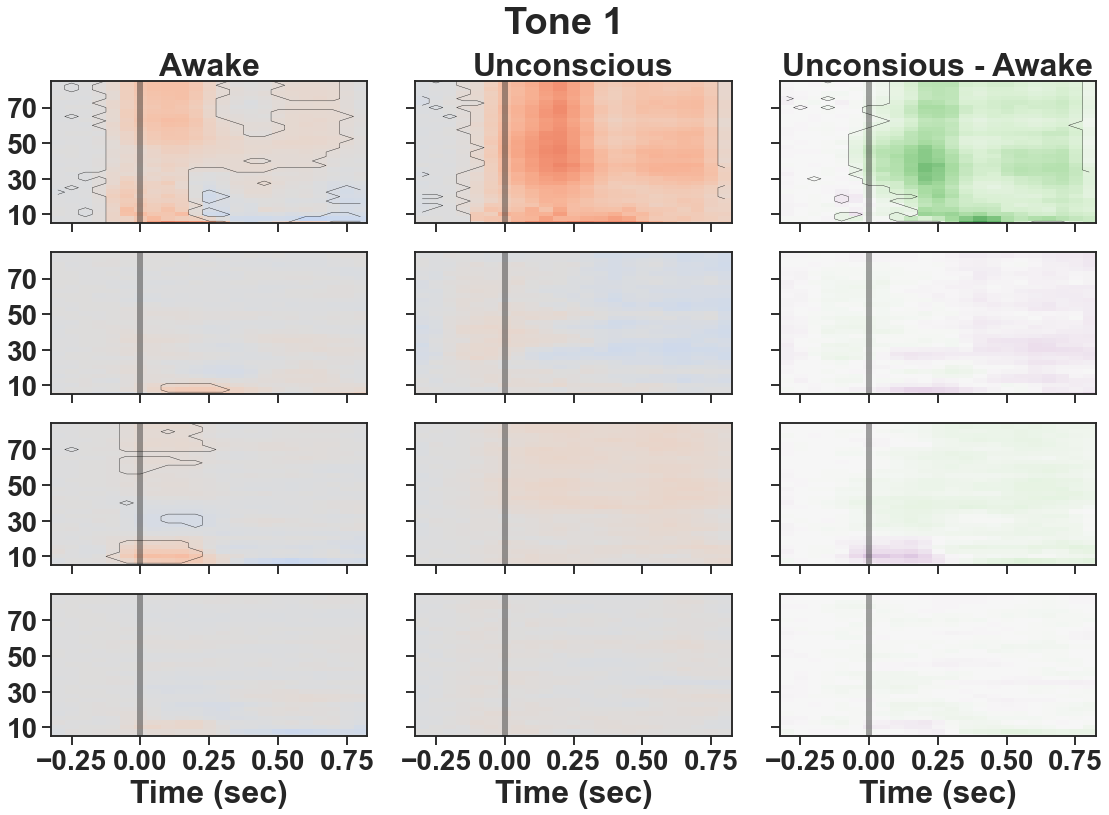

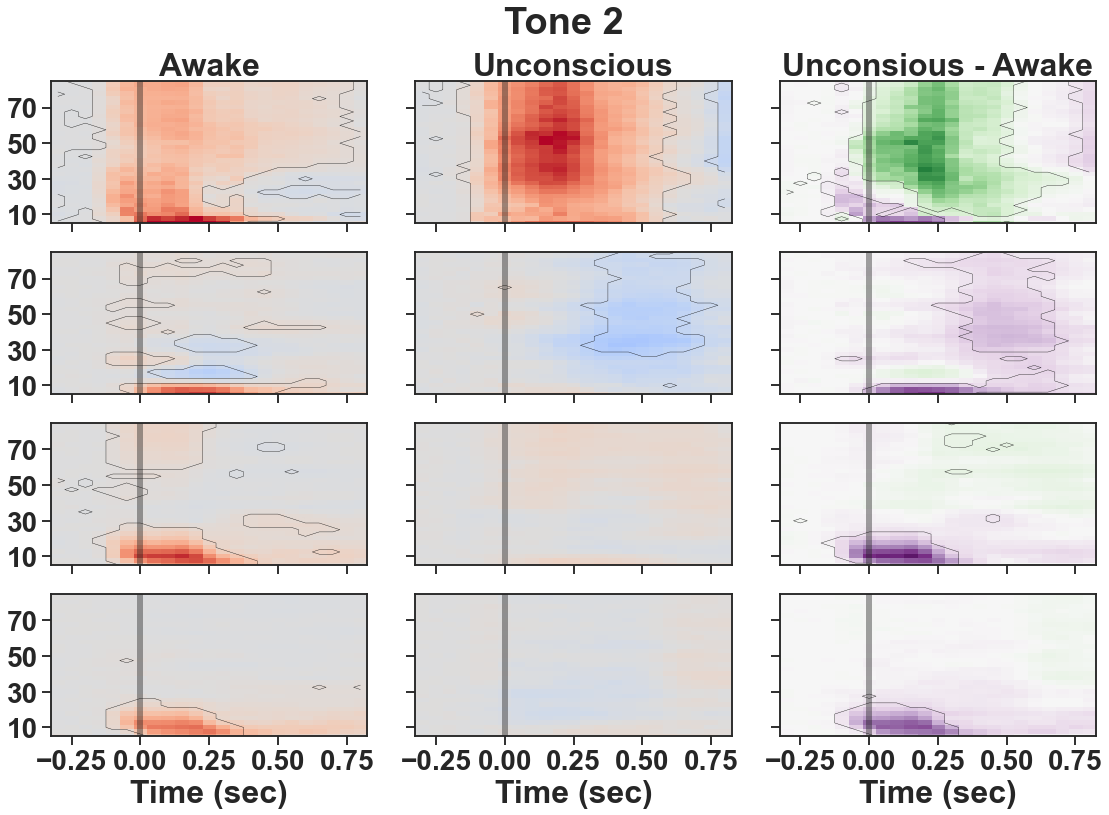

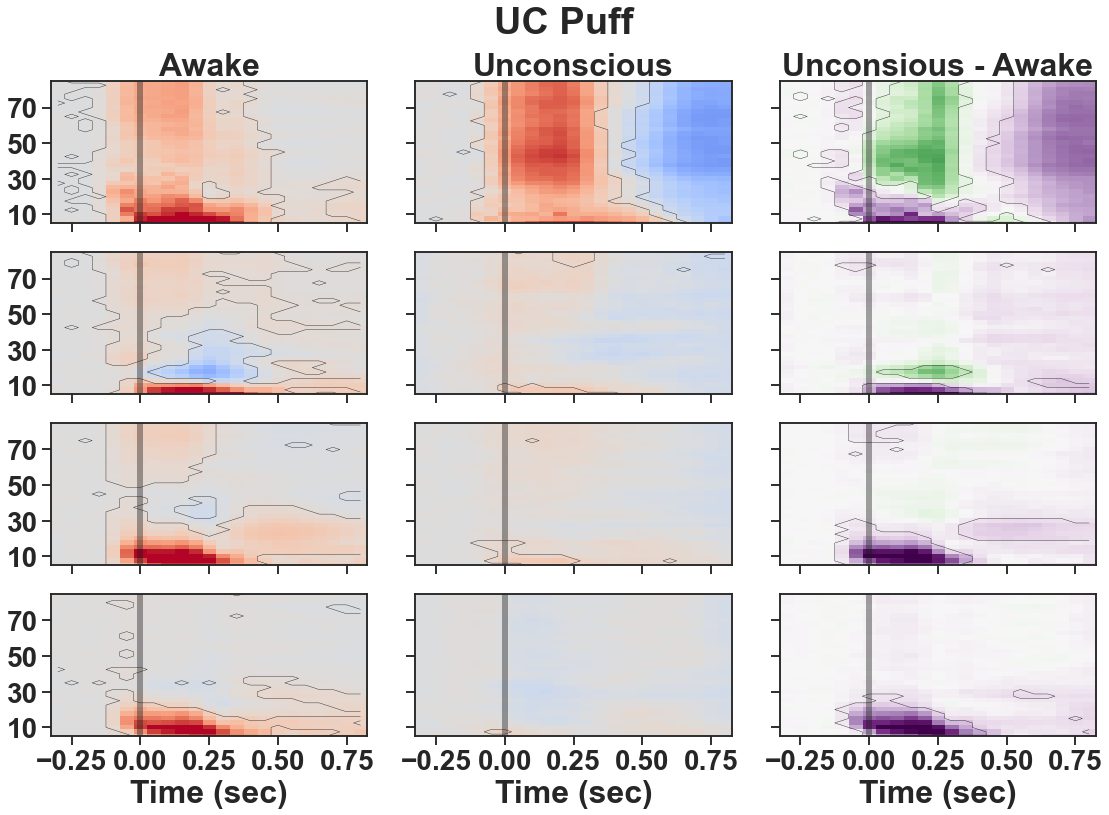

In [59]:
for stim in stims_print:
    plot_db_change_results_new(stim, 5, 90)
    if save_figs == True:
        plt.savefig(f'{save_folder}/{stim}_total_power_results.png', dpi=300)
        plt.savefig(f'{save_folder}/{stim}_total_power_results.pdf', transparent=True)

In [49]:
def plot_colorbar():
    
    fig, ax = plt.subplots(figsize=(10,2))
    tick_fontsize = 28
    
    low = -5
    high = 5
    
    area = 'CPB'
    stim = 'tone_only'
    awake = db_change_results.loc[:,'awake',area,stim,:,:].mean('session')
    freq = db_change_results.freqs

    im = plot_spectrogram(timepts - 0.5, freq, awake, cmap='coolwarm', clim=[low, high])
    
    fig.colorbar(im, ax, orientation='horizontal')
    ax.set_title(r'dB change from baseline', size='30', weight='bold')
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    fig.tight_layout()

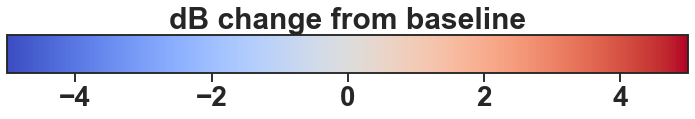

In [51]:
plot_colorbar()
plt.savefig(f'{save_folder}/colorbar_db_change.png', dpi=300)
plt.savefig(f'{save_folder}/colorbar_db_change.pdf', transparent=True)

In [56]:
def plot_colorbar_stats():
    
    fig, ax = plt.subplots(figsize=(10,2))
    tick_fontsize = 28
    
    low = -5
    high = 5
    
    area = 'CPB'
    stim = 'tone_only'
    awake = db_change_results.loc[:,'awake',area,stim,:,:].mean('session')
    drug = db_change_results.loc[:,'drug2',area,stim,:,:].mean('session')
    freq = db_change_results.freqs

    im = plot_spectrogram(timepts - 0.5, freq, drug-awake, cmap='PRGn', clim=[low, high])
    
    
    fig.colorbar(im, ax, orientation='horizontal')
    ax.set_title(r'dB change (propofol - awake)', size='30', weight='bold')
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    fig.tight_layout()

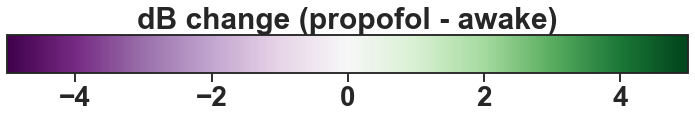

In [57]:
plot_colorbar_stats()
# plt.savefig('colorbar_db_stats.png', dpi=300)
plt.savefig(f'{save_folder}/colorbar_db_stats.png', dpi=300)
plt.savefig(f'{save_folder}/colorbar_db_stats.pdf', transparent=True)